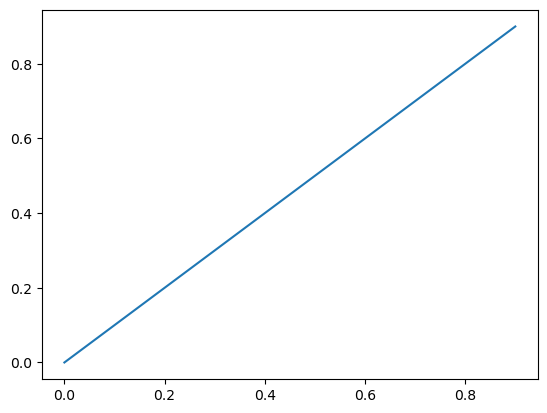

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,1,0.1)
plt.figure()
plt.plot(x,x)
plt.show()

In [2]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from nflows.transforms import made
from NFconstants import N_nod, Beta, a, K_nod
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from NFconstants import N_nod, Beta, a, K_nod
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)

O8=(torch.tensor(get_O(8)).float()).to(device)
O8t=(torch.t(O8)).to(device)


#C=(torch.tensor(get_C(N_nod,Beta)).float()).to(device)
#Ct=(torch.t(C)).to(device)




False


In [4]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [5]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1 = torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det

    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        x1, x2 = x[:,mask1], x[:,mask2]
        x1 = torch.cat((x1,params),dim=-1)
        t, s = self.theta(x1)
        z1, z2 = x1, torch.exp(-s)*(x2-t) 
        log_det = s.sum(-1) 
        x[:,mask2] = z2
        return x, log_det    

In [6]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    

In [7]:
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks

In [8]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], ort=False, Ot=[]):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.Ot = Ot
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
        #split_masks_d = get_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x = torch.matmul(x,self.Ot.to(x.device))
            
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> Tuple[torch.Tensor, torch.Tensor]:
        
        with torch.no_grad():
            if self.ort:
                x=torch.matmul(x,O.to(x.device))
        
            z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(x.device)
        
            for flow in self.flows:
                z, log_abs_det = flow.f(z,params)
                sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n'

In [9]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks
    

In [83]:
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,
                 nflist, 
                 masks, 
                 n_flows_dict,
                 num_hidden_dict,
                 hidden_dim_dict,
                 gr_ng=0,
                 out_dim=N_nod,
                 p_drop=0):
        super().__init__()
        self.latent = latent
        self.nflist = nflist
        self.masks = masks
        self.n_flows_dict = n_flows_dict
        self.num_hidden_dict = num_hidden_dict
        self.hidden_dim_dict = hidden_dim_dict
        self.out_dim = out_dim
        self.gr_ng = gr_ng
        O=(torch.tensor(get_O(self.out_dim)).float()).to(device)
        self.Ot=(torch.t(O)).to(device)
        self.p_drop=p_drop
        
    def set_out_dim(self,out_dim):
        self.out_dim=out_dim
        O=(torch.tensor(get_O(self.out_dim)).float()).to(device)
        self.Ot=(torch.t(O)).to(device)
        
    def configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=0):  
        nflist=[]
        dim = len(masks[0])
        param_dim = 0
        for k in range(len(masks)):
            flows =  NormalizingFlow.configure_flows(n_flows = n_flows_dict[dim] , num_hidden = num_hidden_dict[dim] , hidden_dim = hidden_dim_dict[dim], dim = dim , param_dim = param_dim, p_drop = p_drop)
            nflist.append(NormalizingFlow(latent=normal_dist,flows=flows,ort=False))
            param_dim += dim 
            if k!=0: dim *= 2 
        nflist = nn.ModuleList(nflist)        
        return nflist    
        
    def configure_RG_model(latent,masks,n_flows_dict, num_hidden_dict,hidden_dim_dict,out_dim=N_nod,gr_ng=0,p_drop=0):
        flows=RGflows.configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=p_drop)
        return RGflows(latent,flows,RGmasks,n_flows_dict,num_hidden_dict,hidden_dim_dict,gr_ng=gr_ng,out_dim=out_dim,p_drop=p_drop)
    
    def save(self,filename):
        state_dict = self.state_dict()
        model_dict={"state_dict":state_dict,
                    "n_flows_dict":self.n_flows_dict,
                    "num_hidden_dict":self.num_hidden_dict,
                    "hidden_dim_dict":self.hidden_dim_dict,
                    "masks":self.masks,
                    "p_drop"=self.p_drop}
        torch.save(model_dict,filename)
    
    def load_model(filename):   
        model_dict = torch.load(filename,map_location = device)
        model=RGflows.configure_RG_model(normal_dist,
                                  model_dict["masks"],
                                  model_dict["n_flows_dict"], 
                                  model_dict["num_hidden_dict"],
                                  model_dict["hidden_dim_dict"],
                                  p_drop=model_dict["p_drop"])
        model.load_state_dict(model_dict["state_dict"])
        return model
        

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        full_mask = []
        
        with torch.no_grad():
            for i in range(0,self.gr_ng):
                x = z[:,self.masks[i]]
                x, log_abs_det = ((self.nflist)[i]).g(x,params)
                sum_log_abs_det += log_abs_det
                params = torch.cat((params,x.detach()),dim=-1)
                z[:,self.masks[i]] = x
                full_mask += self.masks[i]
        
        for i in range(self.gr_ng,len(self.nflist)):
            x = z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x.detach()),dim=-1)
            z[:,self.masks[i]] = x
            full_mask += self.masks[i]          
            if len(full_mask) == self.out_dim:
                full_mask.sort()
                z = torch.matmul(z[:,full_mask],self.Ot.to(z.device))    
                return z, sum_log_abs_det
        
        z = torch.matmul(z,self.Ot.to(z.device))    
        return z, sum_log_abs_det
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        with torch.no_grad():
            sum_log_abs_det = torch.zeros(x.size(0)).to(x.device)
            params=torch.tensor([]).to(x.device)
            x = torch.matmul(x,O.to(x.device))
        
            for i in range(len(self.nflist)):
                z = x[:,self.masks[i]]
                tmp = z.clone()
                z, log_abs_det = ((self.nflist)[i]).f(z,params)
                sum_log_abs_det += log_abs_det
                params = torch.cat((params,tmp.detach()),dim=-1)
                x[:,self.masks[i]] = z    
        return x, sum_log_abs_det
    
    def log_prob(self,x):
        tmp = x.clone()
        z, lad = self.f(tmp)
        log_prob = -torch.sum(z**2/2,dim=-1)-lad
        return log_prob
    
    
    def g_samp(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params = torch.tensor([]).to(z.device)
        res = torch.zeros((z.shape[0],z.shape[1]))
        
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            res1, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x),dim=-1)
            res[:,self.masks[i]] = res1
        res = torch.matmul(res,Ot.to(z.device))    
        return res, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z,grads=False):
        t=z.clone()
        with torch.no_grad():
            x, log_abs_det=self.g(t)


        return x, log_abs_det
    
 

    

SyntaxError: ':' expected after dictionary key (2589919414.py, line 53)

In [84]:
m=3
RGmasks = config_RG_masks(3,N_nod)

In [85]:
print(RGmasks)

[[0, 1, 64, 65, 128, 129, 192, 193], [32, 33, 96, 97, 160, 161, 224, 225], [16, 17, 48, 49, 80, 81, 112, 113, 144, 145, 176, 177, 208, 209, 240, 241], [8, 9, 24, 25, 40, 41, 56, 57, 72, 73, 88, 89, 104, 105, 120, 121, 136, 137, 152, 153, 168, 169, 184, 185, 200, 201, 216, 217, 232, 233, 248, 249], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61, 68, 69, 76, 77, 84, 85, 92, 93, 100, 101, 108, 109, 116, 117, 124, 125, 132, 133, 140, 141, 148, 149, 156, 157, 164, 165, 172, 173, 180, 181, 188, 189, 196, 197, 204, 205, 212, 213, 220, 221, 228, 229, 236, 237, 244, 245, 252, 253], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63, 66, 67, 70, 71, 74, 75, 78, 79, 82, 83, 86, 87, 90, 91, 94, 95, 98, 99, 102, 103, 106, 107, 110, 111, 114, 115, 118, 119, 122, 123, 126, 127, 130, 131, 134, 135, 138, 139, 142, 143, 146, 147, 150, 151, 154, 155, 158, 159, 162, 163, 166, 167, 170, 171, 174, 175, 178, 179, 182, 183

In [86]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold = 0.001,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [87]:
class MY_Dataset(Dataset):
    def __init__(self, distribution,n_nod):
        super().__init__()
        self.distribution = distribution
        self.n_nod = n_nod
        self.features = torch.tensor(0)
        self.n_sample = 2**14

    def __len__(self):
        return self.n_sample

    def __getitem__(self, index):
        return self.distribution.sample((1,))[0]
    
    def sample(self,n_sample):
        self.features=self.distribution.sample((n_sample,))
        
normal_dist=torch.distributions.Normal(loc=torch.zeros(N_nod), scale=torch.ones(N_nod))
DS=MY_Dataset(normal_dist,N_nod)
train_loader = DataLoader(DS, batch_size=2**10, shuffle=True)

normal_dist8=torch.distributions.Normal(loc=torch.zeros(8), scale=torch.ones(8))
DS8=MY_Dataset(normal_dist8,8)
train_loader8 = DataLoader(DS8, batch_size=2**14, shuffle=True)

In [88]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
from NFnonrel_Columb import NonRel_Columb
from NFbadur_oscillator import BadUr_Oscillator
from NFtwowells import Two_wells
from NFcircle import Circle
from NFrel_twowells import Rel_two_wells 

osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()

rel1=Rel_Oscillator(N_nod,Beta,sigma=1)
KL_rel1=rel1.get_KL()

ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

ur8=Ur_Oscillator(8,Beta)
KL_ur8=ur8.get_KL()

rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1)
KL_rel_columb=rel_columb.get_KL()

tw = Two_wells(N_nod,Beta,g=1,x0=1.41)
KL_tw = tw.get_KL()


morse = Morse(N_nod,Beta,alpha=0.125)
KL_morse = morse.get_KL()

circ = Circle(N_nod,Beta,g=1,x0=4)
KL_circ = circ.get_KL()

rel_morse = Rel_Morse(N_nod,Beta,m=1,alpha=0.125)
KL_rel_morse = rel_morse.get_KL()

rel_tw = Rel_two_wells(N_nod,Beta,m=1,g=1,x0=1.41)
KL_rel_tw = rel_tw.get_KL()

KL_rel001=Rel_Oscillator(N_nod,Beta,sigma=0.01).get_KL()
KL_rel01=Rel_Oscillator(N_nod,Beta,sigma=0.1).get_KL()
KL_rel10=Rel_Oscillator(N_nod,Beta,sigma=10).get_KL()
KL_rel29=Rel_Oscillator(N_nod,Beta,sigma = 2 ** 9).get_KL()
KL_X4=X4(N_nod,Beta,g=0.05).get_KL()
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()
KL_nonrel_columb=NonRel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()


In [89]:
ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

ur8=Ur_Oscillator(8,Beta)
KL_ur8=ur8.get_KL()

ur16=Ur_Oscillator(16,Beta)
KL_ur16=ur16.get_KL()

ur32=Ur_Oscillator(32,Beta)
KL_ur32=ur32.get_KL()

ur32=Ur_Oscillator(32,Beta)
KL_ur32=ur32.get_KL()

ur64=Ur_Oscillator(64,Beta)
KL_ur64=ur64.get_KL()

ur128=Ur_Oscillator(128,Beta)
KL_ur128=ur128.get_KL()

KL_ur_list=[KL_ur8,KL_ur16,KL_ur32,KL_ur64,KL_ur128,KL_ur]

In [90]:
KL_rel_list=[]
for k in range(m,K_nod+1):
    rel_tmp = Rel_Oscillator(2**k,Beta,sigma=1)
    KL_rel_list.append(rel_tmp.get_KL())

In [91]:
hidden_dim_dict1={8:32,16:64,32:128,64:256,128:512}
n_flows_dict1={8:8,16:16,32:24,64:24,128:32}
num_hidden_dict1={8:8,16:12,32:14,64:14,128:14}

In [97]:
set_random_seed(42)
rg = RGflows.configure_RG_model(normal_dist,RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1,p_drop=0.1)
rg.save("model_weights_ur.pth")
print(rg)

RGflows(
  (nflist): ModuleList(
    (0): NormalizingFlow(
      (flows): ModuleList(
        (0-7): 8 x AffineCouplingLayer(
          (theta): ThetaNetwork(
            (input): Linear(in_features=4, out_features=32, bias=True)
            (hidden): ModuleList(
              (0-7): 8 x Sequential(
                (0): Linear(in_features=32, out_features=32, bias=True)
                (1): Dropout(p=0.1, inplace=False)
                (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              )
            )
            (dims): Linear(in_features=32, out_features=8, bias=True)
          )
        )
      )
    )
    (1): NormalizingFlow(
      (flows): ModuleList(
        (0-7): 8 x AffineCouplingLayer(
          (theta): ThetaNetwork(
            (input): Linear(in_features=12, out_features=32, bias=True)
            (hidden): ModuleList(
              (0-7): 8 x Sequential(
                (0): Linear(in_features=32, out_features=32, bias=True)
                (1): Drop

In [103]:
set_random_seed(42)
rg = RGflows.load_model("model_weights_ur.pth")
d = 5
dim = 2**(m+d)
rg.gr_ng = d
rg.set_out_dim(dim)
pipeline=Pipeline(model=rg,criterion=KL_ur_list[d], optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.0001})

trainer = pl.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights_ur.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | RGflows   | 153 M 
1 | loss  | KL_with_S | 0     
------------------------------------
153 M     Trainable params
0         Non-trainable params
153 M     Total params
614.249   Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [104]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
d = 5
dim = 2**(m+d)
RG_trained = RGflows.load_model("model_weights_ur.pth")
RG_trained.eval()
RG_trained.set_out_dim(dim)
N_traj=1000
trajs = RG_trained.sample(N_traj)

In [105]:
from NFandist import get_T
from tqdm import tqdm
#T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p="all"):
    n_traj=X.shape[0]
    n_nod=X.shape[1]
    if n_p == "all":
        n_p = X.shape[1]
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.roll(Y,-1,1)
        #Y=torch.roll(Y,-1,1)
    return G/(n_traj*n_nod)
g_nf=G(trajs)



100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:06<00:00, 41.19it/s]


In [23]:
print(len(g_nf))

256


In [61]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [130]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [27]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [106]:
g_ur = np.genfromtxt("g_ur N=256 Beta=16")

In [34]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [24]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [30]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [31]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


In [29]:
print(len(g_nf2))

64


0.628837158203125


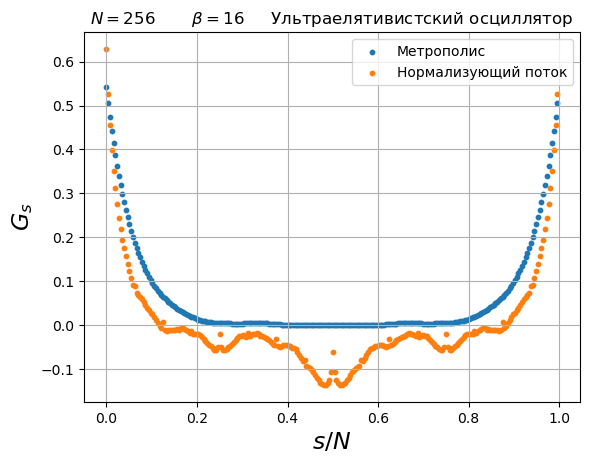

In [108]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta




g=g_ur
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)



plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.legend(["Метрополис","Нормализующий поток"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Ультраелятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()


In [3]:


! du -sh logs






20K	logs


In [4]:
! rm -rf logs


In [41]:
import time
class MCMC:
    def __init__(self,system,model="none",d=(a/N_nod)**0.5,N_sweep=100,log_per=1000):
        
        self.system = system
        self.S = 0
        self.model = model
        self.d = d
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
        
    def sweep(self,z):
        shift = self.shift_dist.sample((N_samp,)).to(z.device)
        y = z+self.d*(2*shift-1)
    
        S_new=self.calc_S(y)
    
        dS=S_new-self.S
        prob = torch.exp(-dS)
        #prob=torch.zeros((N_samp))
        ind = self.un.sample((N_samp,)).to(z.device)<prob
    
        mask=ind.nonzero()
        if len(mask)>1:
            mask=mask.squeeze()
    
        if  len(mask)>0:
            self.S[mask]=S_new[mask]
            z[mask,:]=y[mask,:]  
        self.ar = torch.mean(ind.type('torch.FloatTensor'))           
    
    
    def log(self,z):
        if self.model=="none":
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device)
        else:
            x , lad = self.model(z)
            S=self.system.Full_S(x).to(z.device)-lad   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]
        
    
    def run(self,z):
        
        self.init_state(z)
    
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(z)
            self.sweep(z)
        
        return z    
    
    
        

In [42]:
N_samp = 1000
model1 = RG_trained.to(device)
set_random_seed(42)
z2 = normal_dist.sample((N_samp,)).to(device)
z2,_=model1(z2)
Metropolis_b = MCMC(ur,N_sweep=1000000,log_per=1000,d=(a/N_nod)**0.5)
z2 = Metropolis_b.run(z2)

tensor(0.2936) 0
tensor(0.3064) tensor(0.3690)


KeyboardInterrupt: 

In [22]:
import time
class HMC:
    def __init__(self,system,model="none",eps=0.001,n_steps=10,sigma=1,N_sweep=100,log_per=1000,gamma=0,auto=True,imp=False):
        self.system = system
        self.S = 0
        self.model = model
        self.eps = eps
        self.n_steps = n_steps
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.sigma=sigma
        self.shift_dist = torch.distributions.Normal(torch.zeros(N_nod), sigma * torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.auto = auto
        self.imp = imp    
        self.res = []
        self.times = []
    
    def leapfrog_step(self,p,x,eps):
        if self.auto:
            F = self.calc_F(x)
        else:
            F = self.system.F(x)
            
        p_half = p + 0.5 * eps * F  # F=-dS/dx
        y = x + eps * p_half
        q = p_half + 0.5 * eps * F 
        return q, y

    def hmc_new(self,P,X):
        for i in range(self.n_steps): 
            P , X = self.leapfrog_step(P,X,self.eps)
        return P,X       


    def hmc_sweep(self,x):
        p = self.shift_dist.sample((N_samp,)).to(x.device)
        K0 = torch.sum(p**2/2,axis=1)
        
        q , y = self.hmc_new(p.clone(),x.clone())
        S_new = self.calc_S(y)
        dS = S_new-self.S + torch.sum(q**2/2,axis=1)-K0
        
        prob = torch.exp(-dS)
        ind = self.un.sample((N_samp,)).to(x.device)<prob
        mask = ind.nonzero()
        
        if len(mask)>1:
            mask = mask.squeeze()
        if  len(mask)>0:
            self.S[mask] = S_new[mask]
            x[mask,:] = y[mask,:]
        
        self.ar = torch.mean(ind.type('torch.FloatTensor'))    
    
    
    def log(self,z):
        if self.model=="none" or self.imp:
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z,grads=False):
        
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device) 
        
        
        else:
            
            if self.imp==False:
                if grads :
                    x , lad = self.model.g_samp(z)
                else:
                    x , lad = self.model(z)
                S = self.system.Full_S(x).to(z.device)-lad
            
            
            
            else:
                S = self.system.Full_S(z)+self.model.log_prob(z)
        
        
        return S
    
    def calc_F(self,z):
        t = z.clone()
        t.requires_grad = True
        s = torch.sum(self.calc_S(t,grads=True))
        s.backward()
        F =-(t.grad).detach()
        del(t)
        return F
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]

    def run(self,x):
        self.init_state(x)
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(x)
            self.hmc_sweep(x)
        return x        

In [63]:
import time
class Langevin:
    def __init__(self,system,eps=0.001,N_sweep=10,log_per=1000):
        self.system = system
        self.eps = eps
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.shift_dist = torch.distributions.Normal(torch.zeros(N_nod), torch.ones(N_nod))
        self.res = []
        self.times = []
    



    def sweep(self,x):
        dw = self.shift_dist.sample((N_samp,)).to(x.device)
        x+= 0.5*self.eps*self.system.F(x) + self.eps**0.5 * dw
        
    def log(self,z):
        print(torch.mean(z**2))
        self.res.append(torch.mean(z**2).cpu())
        self.Times.append(time.time()-self.start)
    
    
    def init_state(self):
        self.start=time.time()
        self.res=[]
        self.Times=[]

    def run(self,x):
        self.init_state()
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(x)
            self.sweep(x)
        return x        

In [64]:
N_samp = 1000
model1 = RG_trained.to(device)
set_random_seed(42)
z = normal_dist.sample((N_samp,)).to(device)
Lang = Langevin(ur,N_sweep=100000,log_per=1000,eps=0.001)
z = Lang.run(z)

tensor(1.0053)
tensor(0.6262)
tensor(0.5172)
tensor(0.4693)
tensor(0.4466)
tensor(0.4362)
tensor(0.4316)
tensor(0.4318)
tensor(0.4340)
tensor(0.4387)
tensor(0.4434)
tensor(0.4491)
tensor(0.4562)
tensor(0.4603)
tensor(0.4614)
tensor(0.4670)
tensor(0.4711)
tensor(0.4761)
tensor(0.4803)
tensor(0.4837)
tensor(0.4892)
tensor(0.4988)
tensor(0.4996)
tensor(0.5023)
tensor(0.5005)
tensor(0.5046)
tensor(0.5074)
tensor(0.5129)
tensor(0.5152)
tensor(0.5181)
tensor(0.5206)
tensor(0.5249)
tensor(0.5193)
tensor(0.5222)
tensor(0.5230)
tensor(0.5229)
tensor(0.5236)
tensor(0.5271)
tensor(0.5290)
tensor(0.5313)
tensor(0.5352)
tensor(0.5377)
tensor(0.5395)
tensor(0.5426)
tensor(0.5432)
tensor(0.5503)
tensor(0.5495)
tensor(0.5550)
tensor(0.5596)
tensor(0.5573)
tensor(0.5541)


KeyboardInterrupt: 

In [65]:
N_samp = 1000
model1 = RG_trained.to(device)
set_random_seed(42)
z = normal_dist.sample((N_samp,)).to(device)
z,_ = model1(z)
Lang_NN = Langevin(ur,N_sweep=100000,log_per=1000,eps=0.001)
z = Lang_NN.run(z)

tensor(0.6389)
tensor(0.5498)
tensor(0.5362)
tensor(0.5297)
tensor(0.5258)
tensor(0.5257)
tensor(0.5241)
tensor(0.5220)
tensor(0.5226)
tensor(0.5257)
tensor(0.5251)
tensor(0.5267)
tensor(0.5260)
tensor(0.5266)
tensor(0.5229)
tensor(0.5270)
tensor(0.5294)
tensor(0.5296)
tensor(0.5320)
tensor(0.5324)
tensor(0.5334)


KeyboardInterrupt: 

In [75]:
N_samp = 1000
model1 = RG_trained.to(device)
set_random_seed(42)
z = normal_dist.sample((N_samp,)).to(device)
z,_ = model1(z)
Lang_NN_old = Langevin(ur,N_sweep=100000,log_per=1000,eps=0.001)
z = Lang_NN_old.run(z)

tensor(0.2117)
tensor(0.2768)
tensor(0.3178)
tensor(0.3484)
tensor(0.3709)
tensor(0.3911)
tensor(0.4075)
tensor(0.4215)
tensor(0.4360)
tensor(0.4504)
tensor(0.4599)
tensor(0.4702)
tensor(0.4774)
tensor(0.4837)
tensor(0.4848)
tensor(0.4933)
tensor(0.4983)
tensor(0.5013)
tensor(0.5065)
tensor(0.5092)
tensor(0.5120)
tensor(0.5203)
tensor(0.5201)
tensor(0.5207)
tensor(0.5170)
tensor(0.5211)
tensor(0.5242)
tensor(0.5284)
tensor(0.5286)
tensor(0.5312)
tensor(0.5320)
tensor(0.5352)
tensor(0.5296)
tensor(0.5320)
tensor(0.5323)
tensor(0.5320)
tensor(0.5329)
tensor(0.5349)
tensor(0.5368)
tensor(0.5388)
tensor(0.5418)
tensor(0.5435)
tensor(0.5454)
tensor(0.5485)
tensor(0.5480)
tensor(0.5558)
tensor(0.5545)
tensor(0.5591)
tensor(0.5634)
tensor(0.5603)
tensor(0.5560)
tensor(0.5559)
tensor(0.5544)
tensor(0.5575)
tensor(0.5559)
tensor(0.5513)
tensor(0.5519)
tensor(0.5519)
tensor(0.5522)
tensor(0.5514)
tensor(0.5488)
tensor(0.5519)
tensor(0.5505)
tensor(0.5546)
tensor(0.5524)
tensor(0.5533)
tensor(0.5

KeyboardInterrupt: 

In [73]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_nf=G(z)


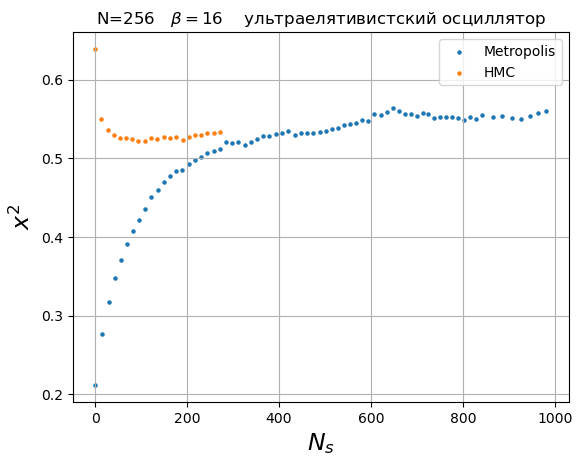

In [76]:

import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta



fig=plt.figure()
#plt.scatter(Metropolis_b.Times,Metropolis_b.res,s=5)
plt.scatter(Lang_NN_old.Times,Lang_NN_old.res,s=5)
plt.scatter(Lang.Times,Lang.res,s=5)
plt.xlabel(r"$N_s$",fontsize=17)
plt.ylabel(r"$x^2$",fontsize=17)
plt.legend(["Metropolis","HMC","HMC latent","Normalizing flow+HMC"])
plt.title("N="+str(N_nod)+"   "+r"$\beta=$"+str(Beta)+"    ультраелятивистский осциллятор")
plt.grid(True)
plt.show()

In [32]:
z = torch.ones(10)
z.requires_grad=True
print(z.requires_grad)
x = z
x = 2*x**2
print(y.requires_grad)
x[0].backward()
print(z)
print(z.grad)

True
True
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [63]:
t=z.clone()
print(t.requires_grad)

True


In [2]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks